# Chapter 7

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## オブザーバ

In [5]:
from control.matlab import ss, acker, lsim

In [8]:
A = '0 1; -4 -5'
B = '0; 1'
C = '1 0'
D = '0'
P = ss(A, B, C, D)
print(P)

# A = '0 1; -4 -5'
# B = '0; 1'
# C = '1 0; 0 1'
# D = '0; 0'
# Ps = ss(A, B, C, D)
# print(Ps)

<LinearIOSystem>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4. -5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



### オブザーバゲインの設計（極配置）

In [10]:
# オブザーバ極
observer_poles=[-10+5j,-10-5j]

# オブザーバゲインの設計（状態フィードバックの双対） 
L = -acker(P.A.T, P.C.T, observer_poles).T
print(L)

[[-15.]
 [-46.]]


In [11]:
np.linalg.eigvals(P.A + L * P.C)

array([-10.+5.j, -10.-5.j])

In [12]:
G = ss(P.A, P.B, np.eye(2), [[0],[0]])
Obs = ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

In [13]:
Obs.pole()

array([-10.+5.j, -10.-5.j])

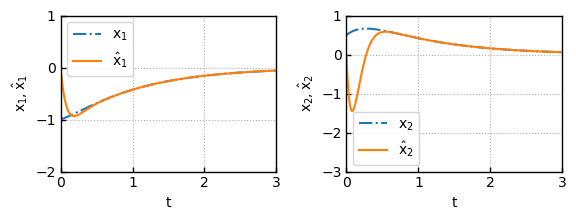

In [14]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
# 入力 u = Fx
u = np.zeros_like(Td)
# u = 10*np.sin(10*T)

x, t, _ = lsim(G, u, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')

# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
xhat, t, _ = lsim(Obs, np.c_[u, y], Td, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    plot_set(ax[i], 't', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 1])
ax[1].set_ylim([-3, 1])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
# fig.savefig("obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 出力フィードバック

In [16]:
from control.matlab import tf, feedback, initial

# レギュレータ極
regulator_poles = [-5+2j, -5-2j]
# 極配置
F = -acker(P.A, P.B, regulator_poles)
print(F)

[[-25.  -5.]]


In [17]:
# 出力フィードバック（オブザーバ＋状態フィードバック）
K = ss(P.A+P.B*F+L*P.C, -L, F, 0)
print('K:\n', K)
print('----------------')
print('K(s)=', tf(K))
 
# フィードバック系
Gfb = feedback(P, K, sign=1)

K:
 <LinearIOSystem>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-15.   1.]
     [-75. -10.]]

B = [[15.]
     [46.]]

C = [[-25.  -5.]]

D = [[0.]]

----------------
K(s)= 
 -605 s - 2725
----------------
s^2 + 25 s + 225



(-1.5, 0.5)

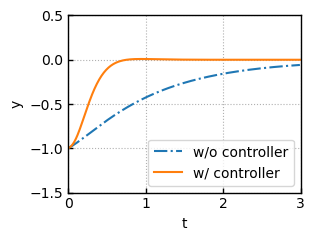

In [18]:
fig, ax = plt.subplots(figsize=(3, 2.3))
Td = np.arange(0, 3, 0.01)

y, t = initial(P, Td, [-1, 0.5])
ax.plot(t,y, ls='-.', label='w/o controller')

y, t = initial(Gfb, Td, [-1, 0.5, 0, 0])
ax.plot(t,y, label='w/ controller')

plot_set(ax, 't', 'y', 'best')
ax.set_xlim([0, 3])
ax.set_ylim([-1.5, 0.5])

# fig.savefig("obs2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 外乱オブザーバ

出力に0.5の定値外乱が加わるとする

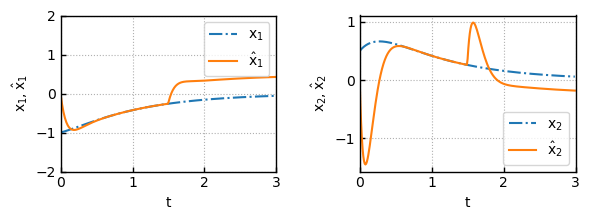

In [25]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(Td>=1.5)

G = ss(P.A, P.B, np.eye(2), [[0],[0]])
x, t = initial(G, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')

# 入力 u
u = np.zeros_like(Td)
# 出力 y = Cx+d
y = x[:, 0]+d
Obs = ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

xhat, t, _ = lsim(Obs, np.c_[u, y], Td, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('t')
    ax[i].legend()

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
# fig.savefig("dis_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

In [21]:
# オブザーバ極
observer_poles=[-10+5j,-10-5j, -3] 

# オブザーバゲインの設計（状態フィードバックの双対）

Abar = np.block( [ [P.A, np.zeros([2,1])], [np.zeros((1,3))] ])
Bbar = np.block( [ [P.B], [0] ])
Cbar = np.block( [ P.C, 1 ] )

Lbar = -acker(Abar.T, Cbar.T, observer_poles).T
print(Lbar)

Aob = Abar + Lbar*Cbar
Bob = np.block([Bbar, -Lbar])
Obs = ss(Aob, Bob, np.eye(3), np.zeros([3,2]) )

[[ 75.75]
 [-91.  ]
 [-93.75]]


In [22]:
Obs.pole()

array([-10.+5.j, -10.-5.j,  -3.+0.j])

(-0.5, 2.0)

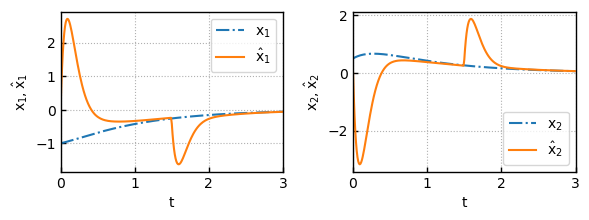

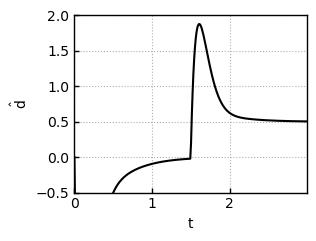

In [24]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(Td>=1.5)
x, t = initial(G, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')


# 入力 u = Fx
u = np.zeros_like(Td)
# 出力 y = Cx+d
y = x[:, 0]+d
xhat, t, _ = lsim(Obs, np.c_[u, y], Td, [0, 0, 0])
#xhat, t, x0 = lsim(Obs, x[:, 0]+d, T, [0, 0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('t')
    ax[i].legend()

ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
fig.savefig("dis_obs2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, xhat[:, 2], label='$\hat{x}_2$', color='k')
ax.grid(ls=':')
ax.set_xlabel('t')
ax.set_ylabel('$\hat{d}$')
ax.set_ylim([-0.5, 2])

外乱 0.5 が推定できている

### 定常カルマンフィルタ

In [9]:
from control.matlab import ss, lqe, lsim

In [10]:
A = '0 1; -4 -5'
B = '0; 1'
C = '1 0'
D = '0'
P = ss(A, B, C, D)
print(P)

<LinearIOSystem>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4. -5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



In [11]:
QN = 1
RN = 1
L, X, _ = lqe(P.A, P.B, P.C, QN, RN)
L = -L
print(L)

[[-0.0245608 ]
 [-0.00030162]]


1.0441977177232362
0.051633493650512736
[[-0.0245608 ]
 [-0.00030162]]


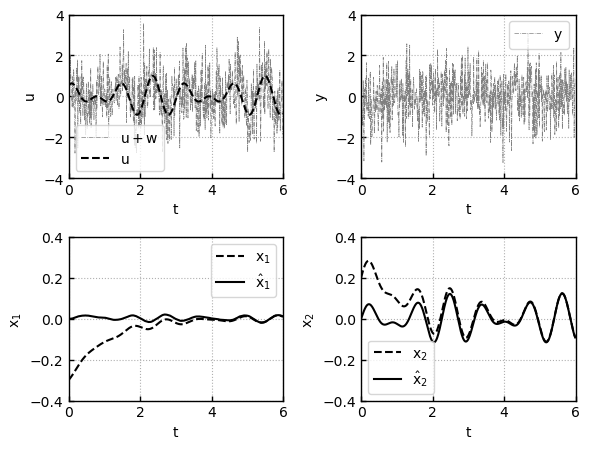

In [13]:
Td = np.arange(0, 6, 0.01)
u = 0.5 * np.sin(6*Td) + 0.5 * np.cos(8*Td)

QN, RN = 1, 1
w = np.random.normal(loc=0, scale=np.sqrt(QN), size=len(Td))
v = np.random.normal(loc=0, scale=np.sqrt(RN), size=len(Td))

print(np.var(w))
print(np.mean(w))

L, _, _ = lqe(P.A, P.B, P.C, QN, RN)
L = -L
print(L)
# L = np.matrix([[-1], [-1]])
Obs = ss(P.A + L*P.C, np.block([P.B, -L]), np.eye(2), np.zeros([2,2]))

X0 = [-0.3, 0.2]
_, t, x = lsim(P, u+w, Td, X0)
_, t, xorg = lsim(P, u, Td, X0)

# 出力 y = Cx
y = x[:, 0]+v

fig, ax = plt.subplots(2,2, figsize=(6, 4.6))
ax[0,1].plot(t, y,   ls='-.', label='$y$', c='gray', lw=0.5)
ax[1,0].plot(t, xorg[:,0],   ls='--', label='$x_1$', c='k')
ax[1,1].plot(t, xorg[:,1],   ls='--', label='$x_2$', c='k')
ax[0,0].plot(t, u+w, ls='-.', label='$u+w$', c='gray', lw=0.5)

# 入力 u = Fx
#u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
#u = np.sin(T)
#u = 0*(T>0)

# オブザーバで推定した状態の振る舞い
xhat, t, _ = lsim(Obs, np.c_[u, y], Td, [0, 0])
ax[1,0].plot(t, xhat[:, 0], label='$\hat{x}_1$', c='k')
ax[1,1].plot(t, xhat[:, 1], label='$\hat{x}_2$', c='k')
ax[0,0].plot(t, u, label='$u$', c='k', ls='--')

for i in [0, 1]:
    for j in [0, 1]:
        plot_set(ax[i,j], '$t$', '', 'best')
        ax[i,j].set_xlim([0, 6])

ax[0,1].set_ylim([-4, 4])
ax[0,1].set_ylabel('$y$')
ax[0,0].set_ylabel('$u$')
ax[0,0].set_ylim([-4, 4])
ax[1,0].set_ylim([-0.4, 0.4])
ax[1,0].set_ylabel('$x_1$')
ax[1,1].set_ylim([-0.4, 0.4])
ax[1,1].set_ylabel('$x_2$')


fig.tight_layout()
# fig.savefig("ex_kalman.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## ロバスト制御

In [5]:
from control.matlab import tf, bode, logspace, mag2db, ss2tf, step, feedback

In [6]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]

### 乗法的不確かさ

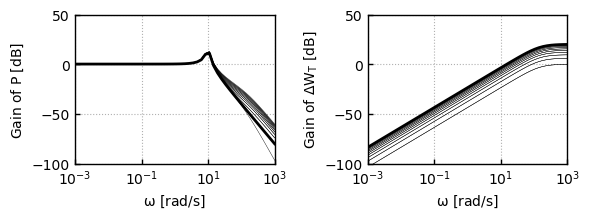

In [7]:
# 垂直駆動アームのノミナルモデル
Pn = tf( [0,1], [J, mu, M*g*l] )

# Pn = tf( [0, 1], [1, 1])
# 不確かさ
delta = np.arange(-1, 1 , 0.1)
WT = tf( [10, 0], [1, 150])

fig, ax = plt.subplots(1, 2, figsize=(6,2.3))
# fig, ax = plt.subplots(1, 2)

for i in range(len(delta)):
    # 不確かさをもつ制御対象
    P = (1 + WT*delta[i])*Pn
    mag, _, w = bode(P, logspace(-3,3), plot=False)

    ax[0].semilogx(w, mag2db(mag), color = 'k', lw = 0.3)
    
    # 乗法的不確かさ
    DT = (P - Pn)/Pn
    mag, _, w = bode(DT, logspace(-3,3), plot=False)

    ax[1].semilogx(w, mag2db(mag), color = 'k', lw = 0.3)

mag, _, w = bode(Pn, logspace(-3,3), plot=False)
ax[0].semilogx(w, mag2db(mag), lw =2, color='k')

mag, _, w = bode(WT, logspace(-3,3), plot=False)
ax[1].semilogx(w, mag2db(mag), lw =2, color='k')

ax[0].set_ylim(-100, 50)
ax[1].set_ylim(-100, 50)
bodeplot_set(ax)
ax[0].set_xlabel('$\omega$ [rad/s]')
ax[0].set_ylabel('Gain of $P$ [dB]')
ax[1].set_ylabel('Gain of $\Delta W_T$ [dB]')
#ax.grid(which="both", ls=':')
#ax.set_ylabel('Gain [dB]')
#ax.set_xlabel('$\omega$ [rad/s]')

fig.tight_layout()
# fig.savefig("robust_plant.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 混合感度問題

K= 
   7.21 s^4 + 1098 s^3 + 3259 s^2 + 1.081e+05 s + 9.032e+04
---------------------------------------------------------------
s^5 + 165.1 s^4 + 2448 s^3 + 2.449e+04 s^2 + 2.273e+04 s + 5540

gamma = 0.9527651218302327


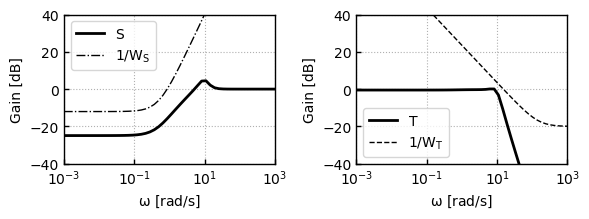

In [8]:
from control import mixsyn

WS = tf( [0, 1], [1, 1, 0.25]) # 感度関数に対する重み関数 
WU = tf(1,1)
WT = tf( [10, 0], [1, 150]) # 相補感度関数に対する重み関数

# 混合感度問題
K, _, info = mixsyn(Pn, w1=WS , w2=WU, w3=WT) 

print('K=', ss2tf(K))
print('gamma =', info[0])

fig, ax = plt.subplots(1, 2, figsize=(6,2.3))

# 感度関数
Ssys = feedback(1, Pn*K)
mag, _, w = bode(Ssys, logspace(-3,3), plot=False)
ax[0].semilogx(w, mag2db(mag), ls= '-', lw =2, label='$S$', color='k')

mag, _, w = bode(1/WS, logspace(-3,3), plot=False)
ax[0].semilogx(w, mag2db(mag), ls= '-.', lw =1, label='$1/W_S$', color='k')

# 相補感度関数
Tsys = feedback(Pn*K, 1)
mag, _, w = bode(Tsys, logspace(-3,3), plot=False)
ax[1].semilogx(w, mag2db(mag), ls = '-', lw =2, label='$T$', color='k')

mag, _, w = bode(1/WT, logspace(-3,3), plot=False)
ax[1].semilogx(w, mag2db(mag), ls= '--', lw =1, label='$1/W_T$', color='k')

for i in range(2):
    ax[i].set_ylim(-40, 40)
    ax[i].legend()
    ax[i].grid(which="both", ls=':')
    ax[i].set_ylabel('Gain [dB]')
    ax[i].set_xlabel('$\omega$ [rad/s]')

fig.tight_layout()
# fig.savefig("robust_design.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

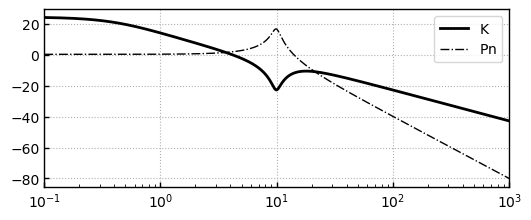

In [9]:
fig, ax = plt.subplots(figsize=(6,2.3))

mag, _, w = bode(K, logspace(-1,3,1000), plot=False)
ax.semilogx(w, mag2db(mag), ls= '-', lw =2, label='$K$', color='k')

mag, _, w = bode(Pn, logspace(-1,3,1000), plot=False)
ax.semilogx(w, mag2db(mag), ls= '-.', lw =1, label='$Pn$', color='k')

ax.legend()
ax.grid(ls=':')

(0.0, 60.0)

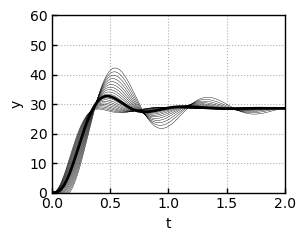

In [10]:
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(len(delta)):
    P = (1 + WT*delta[i])*Pn
    Gyr = feedback(P*K, 1)
    
    y, t = step(Gyr, np.arange(0,5,0.01))

    ax.plot(t, y*ref, color ='k', lw =0.3)

Gyr = feedback(Pn*K, 1)
y, t = step(Gyr, np.arange(0,5,0.01))
ax.plot(t, y*ref, lw =2, color='k')

plot_set(ax, 't', 'y')
ax.set_xlim(0, 2)
ax.set_ylim(0, 60)

# fig.savefig("robust_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### PID制御との比較

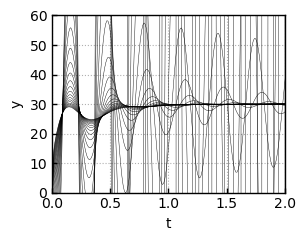

In [11]:
kp = 2
kd = 0.1
ki = 10

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(3,2.3))

for i in range(len(delta)):
    Kpid = tf([kd, kp, ki], [1, 0])
    
    P = (1 + WT*delta[i])*Pn
    Gyr = feedback(P*Kpid, 1)
    y, t = step(Gyr, np.arange(0,5,0.01))
    ax.plot(t, y*ref, color ='k', lw =0.3)
      
ax.set_xlim(0, 2)
ax.set_ylim(0, 60)
plot_set(ax, 't', 'y')

# fig.savefig("robust_comp.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

ナイキスト線図で不確かさの影響を確認する

In [12]:
from control.matlab import nyquist

/Users/minami/opt/anaconda3/envs/bookpython/lib/python3.11/site-packages/control/freqplot.py:943: UserWarning: number of encirclements was a non-integer value; this can happen is contour is not closed, possibly based on a frequency range that does not include zero.
  warnings.warn(
/Users/minami/opt/anaconda3/envs/bookpython/lib/python3.11/site-packages/control/matlab/wrappers.py:113: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  _, contour = nyquist_plot(syslist, omega, *args, **kwargs)


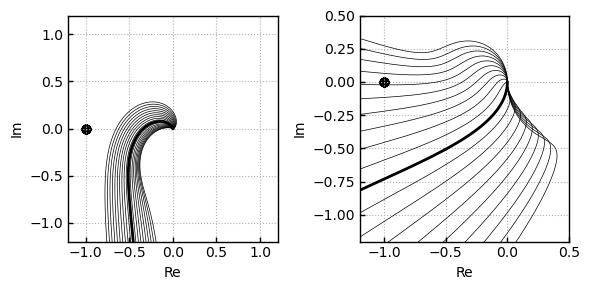

In [13]:
fig, ax = plt.subplots(1,2, figsize=(6, 3))

for i in range(len(delta)):
# ロバスト制御：閉ループ系が安定になる
    
    P = (1 + WT*delta[i])*Pn

    x, y, _ = nyquist(P*K, logspace(-3,5,1000), plot=False)
    ax[0].plot(x, y, lw = 0.5, color='k')
    #ax[0].plot(x, -y, ls='--', color='k')
    ax[0].scatter(-1, 0, color='k')
    plot_set(ax[0], 'Re', 'Im')

# PID制御：閉ループ系が不安定になる
    xpid, ypid, _ = nyquist(P*Kpid, logspace(-3,5,1000), plot=False)
    ax[1].plot(xpid, ypid, lw = 0.5, color='k')
    #ax[1].plot(xpid, -ypid, ls='--', color='k')
    ax[1].scatter(-1, 0, color='k')
    plot_set(ax[1], 'Re', 'Im')

x, y, _ = nyquist(Pn*K, logspace(-3,5,1000), plot=False)
ax[0].plot(x, y, lw = 2, color='k')
ax[0].set_xlim(-1.2, 1.2)
ax[0].set_ylim(-1.2, 1.2)

xpid, ypid, _ = nyquist(Pn*Kpid, logspace(-3,5,1000), plot=False)
ax[1].plot(xpid, ypid, lw = 2, color='k')
ax[1].set_xlim(-1.2, 0.5)
ax[1].set_ylim(-1.2, 0.5)
fig.tight_layout()

# fig.savefig("nyquist_robust.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

左：ロバスト制御，右：PID制御

### おまけ

In [14]:
from control import augw, hinfsyn
G = augw(P, w1=WS, w2=WU, w3=WT)

In [17]:
k, cl, gam, ro= hinfsyn(G, 1, 1)
ss2tf(k)

TransferFunction(array([5.26385918e+00, 1.59156522e+03, 1.22682223e+05, 4.36556203e+05,
       1.19037009e+07, 9.95839882e+06]), array([1.00000000e+00, 3.20437726e+02, 2.89216312e+04, 3.76842182e+05,
       2.79873805e+06, 2.53046728e+06, 6.10856797e+05]))

## ディジタル実装

In [5]:
from control.matlab import tf, c2d, step, lsim

In [6]:
P = tf([0, 1], [0.5, 1])
print('連続時間システム',P)

連続時間システム 
    1
---------
0.5 s + 1



In [7]:
ts = 0.2

Pd1 = c2d(P, ts, method='zoh')
print('離散時間システム（zoh）', Pd1)

Pd2 = c2d(P, ts, method='tustin')
print('離散時間システム（tustin）',Pd2)

離散時間システム（zoh） 
  0.3297
----------
z - 0.6703

dt = 0.2

離散時間システム（tustin） 
0.1667 z + 0.1667
-----------------
   z - 0.6667

dt = 0.2



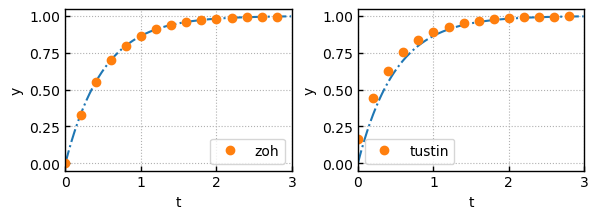

In [11]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Tc = np.arange(0, 3, 0.01)
y, t = step(P, Tc)
ax[0].plot(t, y, ls='-.')
ax[1].plot(t, y, ls='-.')


Td = np.arange(0, 3, ts)
y, t = step(Pd1, Td)
ax[0].plot(t, y, ls='', marker='o', label='zoh')

y, t = step(Pd2, Td)
ax[1].plot(t, y, ls='', marker='o', label='tustin')

for i in [0, 1]:
    plot_set(ax[i], 't', 'y', 'best')
    ax[i].set_xlim([0, 3])

fig.tight_layout()
# fig.savefig("c2d_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

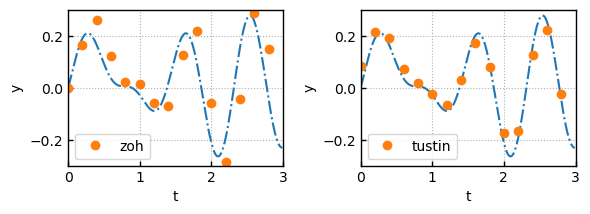

In [10]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Tc = np.arange(0, 3, 0.01)
Uc = 0.5 * np.sin(6*Tc) + 0.5 * np.cos(8*Tc)

y, t, x0 = lsim(P, Uc, Tc)
ax[0].plot(t, y, ls='-.')
ax[1].plot(t, y, ls='-.')


T = np.arange(0, 3, ts)
U = 0.5 * np.sin(6*T) + 0.5 * np.cos(8*T)

y, t, x0 = lsim(Pd1, U, T)
ax[0].plot(t, y, ls='', marker='o', label='zoh')

y, t, x0 = lsim(Pd2, U, T)
ax[1].plot(t, y, ls='', marker='o', label='tustin')

for i in [0, 1]:
    plot_set(ax[i], 't', 'y', 'best')
    ax[i].set_xlim([0, 3])
    ax[i].set_ylim([-0.3, 0.3])

fig.tight_layout()
# fig.savefig("c2d_time.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

In [12]:
from control.matlab import bode, logspace, linspace, mag2db

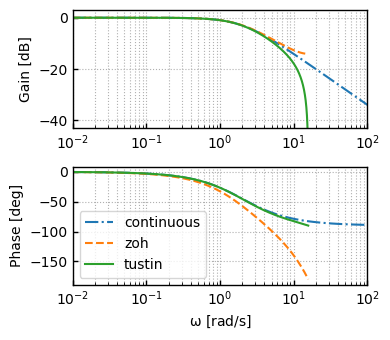

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

mag, phase, w = bode(P, logspace(-2,2), plot=False)
ax[0].semilogx(w, mag2db(mag), ls = '-.', label='continuous')
ax[1].semilogx(w, np.rad2deg(phase), ls = '-.', label='continuous')

# 離散時間システム (0次ホールドによる離散化)
mag, phase, w = bode(Pd1, linspace(0.01, np.pi/ts-0.001, 1000), plot=False)
ax[0].semilogx(w, mag2db(mag), ls = '--', label = 'zoh')
ax[1].semilogx(w, np.rad2deg(phase), ls = '--', label= 'zoh')

# 離散時間システム (双一次変換による離散化)
mag, phase, w = bode(Pd2, linspace(0.01, np.pi/ts-0.001, 1000), plot=False)
ax[0].semilogx(w, mag2db(mag), ls = '-', label = 'tustin')
ax[1].semilogx(w, np.rad2deg(phase), ls = '-', label = 'tustin')

bodeplot_set(ax, 3)

# ナイキスト周波数 w = pi/ts のところに線を引く
ax[0].axvline(np.pi/ts, lw = 0.5, c ='k')
ax[1].axvline(np.pi/ts, lw = 0.5, c ='k')

ax[0].set_ylim([-43, 3])
# ax[0].set_xlim([0.01, np.pi/ts])
# ax[1].set_xlim([0.01, np.pi/ts])

fig.tight_layout()
# fig.savefig("c2d_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

離散時間システム（zoh） 
 0.09516
----------
z - 0.9048

dt = 0.05

離散時間システム（tustin） 
0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.05



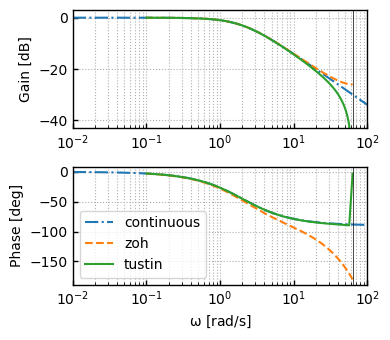

In [21]:
ts = 0.05

Pd1 = c2d(P, ts, method='zoh')
print('離散時間システム（zoh）', Pd1)

Pd2 = c2d(P, ts, method='tustin')
print('離散時間システム（tustin）',Pd2)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

mag, phase, w = bode(P, np.logspace(-2,2), plot=False)
pltargs = {'ls': '-.', 'label': 'continuous'}
ax[0].semilogx(w, mag2db(mag), **pltargs)
ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

# gain, phase, w = bode(Pd1, np.logspace(-2,2), plot=False)
mag, phase, w = bode(Pd1, plot=False)
pltargs = {'ls': '--', 'label': 'zoh'}
ax[0].semilogx(w, mag2db(mag), **pltargs)
ax[1].semilogx(w, np.rad2deg(phase), **pltargs)


# gain, phase, w = bode(Pd2, np.logspace(-2,2), plot=False)
mag, phase, w = bode(Pd2, plot=False)
pltargs = {'ls': '-', 'label': 'tustin'}
ax[0].semilogx(w, mag2db(mag), **pltargs)
ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

bodeplot_set(ax, 3)

# 周波数が w = pi/ts のところに線を引く
ax[0].axvline(np.pi/ts, lw = 0.5, c ='k')
ax[1].axvline(np.pi/ts, lw = 0.5, c ='k')

ax[0].set_ylim([-43, 3])
# ax[0].set_xlim([0.01, np.pi/ts])
# ax[1].set_xlim([0.01, np.pi/ts])

fig.tight_layout()
# fig.savefig("c2d_bode2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### プログラム実装（おまけ）

In [146]:
from control.matlab import tf, tfdata, c2d, step

In [165]:
zeta, omega_n = 0.2, 10
P = tf([omega_n**2], [1, 2*zeta*omega_n, omega_n**2])

ts = 0.2
Pd = c2d(P, ts, method='zoh')
[[[b]], [[a]]] = tfdata(Pd) # 分子・分母多項式の係数を取得

b1, b2 = b
a1, a2 = a[1:]

(0.0, 3.0)

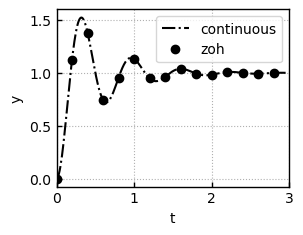

In [166]:
fig, ax = plt.subplots(figsize=(3, 2.3))

Tc = np.arange(0, 3, 0.01)
y, t = step(P, Tc)
ax.plot(t, y, ls='-.', label='continuous', color='k')

Td = np.arange(0, 3, ts)
y, t = step(Pd, Td)
ax.plot(t, y, ls='', marker='o', label='zoh', color='k')

plot_set(ax, 't', 'y', 'best')
ax.set_xlim([0, 3])

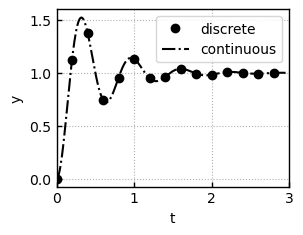

In [167]:
fig, ax = plt.subplots(figsize=(3, 2.3))

# 離散時間システムのステップ応答
uold, uold2 = 0.0, 0.0
yold, yold2 = 0.0, 0.0

Td = np.arange(0, 3, ts)
u = 1.0*(Td>=0) # 単位ステップ入力

for k in range(len(Td)):
    y[k] = b1*uold + b2*uold2 - a1*yold - a2*yold2

    yold2 = yold
    yold = y[k]
    uold2 = uold
    uold = u[k]

ax.plot(Td, y, ls='', marker='o', label='discrete', color='k')

#連続時間システムのステップ応答
yc, t = step(P, np.arange(0, 3, 0.01)) 
ax.plot(t, yc, ls='-.', label='continuous', color='k')

plot_set(ax, 't', 'y', 'best')
ax.set_xlim([0, 3])

fig.savefig("c7_system2program_plot.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

(0.0, 3.0)

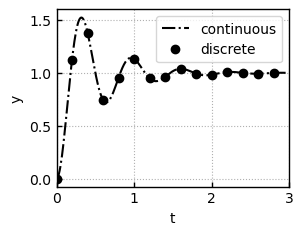

In [168]:
fig, ax = plt.subplots(figsize=(3, 2.3))

Tc = np.arange(0, 3, 0.01)
yc, t = step(P, Tc)
ax.plot(t, yc, ls='-.', label='continuous', c='k')

xold, xold2 = 0.0, 0.0

Td = np.arange(0, 3, ts)
u = 1.0*(Td>=0)

for k in range(len(Td)):
    x = u[k] - a1*xold - a2*xold2
    y[k] = b1*xold + b2*xold2

    xold2 = xold
    xold = x

ax.plot(Td, y, ls='', marker='o', label='discrete', c='k')

plot_set(ax, 't', 'y', 'best')
ax.set_xlim([0, 3])

## 最適制御

In [5]:
import control as ct
import control.optimal as obc

### 有限時間最適制御

１次系

In [6]:
P = ct.ss(1, 1, 1, 0) # システム dxdt=x+u，y=x の記述
sys = ct.ss2io(P) # 状態空間モデルを入出力モデル変換

In [7]:
print(sys.pole())

[1.+0.j]


In [9]:
xf = 0 # 基準状態，終端状態
uf = 0 # 基準入力
Q = 50 # 状態に関する重み
R = 0.1 # 入力に関する重み

# 評価関数の設定
cost = obc.quadratic_cost(sys, Q, R, x0=xf, u0=uf)

# traj_cost = obc.quadratic_cost(sys, R, R, x0=xf, u0=uf)
# term_cost = obc.quadratic_cost(sys, Q, None, x0=xf)

# P = 100
# term_cost = opt.quadratic_cost(sys, P, 0, x0=xf)

# 制約条件の設定
umin, umax = -4, 4
constraints = [ obc.input_range_constraint(sys, [umin], [umax]) ]
terminal = [ obc.state_range_constraint(sys, [xf], [xf]) ]

In [10]:
Td = np.arange(0, 0.5, 0.01) # シミュレーション時間
x0 = 1 # 初期状態

# 最適制御問題を解く
result = obc.solve_ocp(sys, Td, x0, cost=cost, 
                       constraints=constraints, terminal_constraints=terminal)
# result = obc.solve_ocp(sys, Td, x0, cost=traj_cost, terminal_cost=term_cost,
#                        constraints=constraints)
print('最適化成功：', result.success)

Summary statistics:
* Cost function calls: 3535
* Constraint calls: 3672
* Eqconst calls: 3672
* System simulations: 1
* Final cost: 5.585715123369499
最適化成功： True


In [12]:
print("Final_computed_state:",result.states[:,-1]) # 終端状態

Final_computed_state: [0.]


Final_simulated_state: [0.00570882]


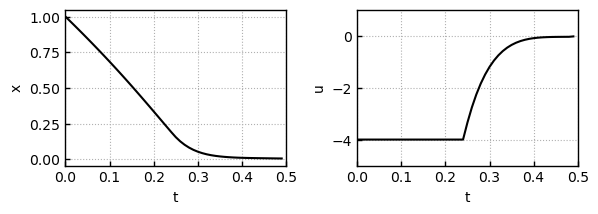

In [13]:
resp = ct.input_output_response(sys, Td, result.inputs, x0)
# t, y = ct.initial_response(sys, Td, x0)

print("Final_simulated_state:", resp.states[:,-1]) # 終端状態

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3)) 
ax[0].plot(resp.time, resp.outputs, c='k')
ax[1].plot(resp.time, resp.inputs, c='k')
# ax[0].plot(t, y)

ax[0].set_xlim([0,0.5])
# ax[0].set_ylim([0,1])
ax[1].set_xlim([0,0.5])
ax[1].set_ylim([-5,1])
plot_set(ax[0], 't', 'x')
plot_set(ax[1], 't', 'u')
plt.tight_layout()
# fig.savefig("c7_obc.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

2次系

In [14]:
A = [ [0, 1], [-4, -5] ]
B = [ [0], [1] ]
C = np.eye(2)
D = np.zeros([2,1])
P = ct.ss(A, B, C, D)
sys = ct.ss2io(P)

In [16]:
xf = [0, 0]
uf = 0
Q = np.diag([100, 1])
R = 0.1
cost = obc.quadratic_cost(sys, Q, R, x0=xf, u0=uf)

constraints = [obc.input_range_constraint(sys, [-15], [15])]

In [17]:
Td = np.arange(0, 1, 0.01)
x0 = [1, 0]
result = obc.solve_ocp(sys, Td, x0, cost=cost, constraints=constraints)
print('最適化成功：', result.success)

Summary statistics:
* Cost function calls: 15351
* Constraint calls: 15704
* System simulations: 1
* Final cost: 29.16562957646857
最適化成功： True


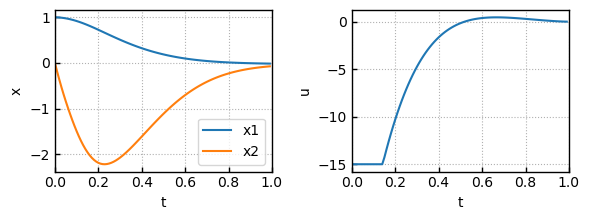

In [18]:
resp = ct.input_output_response(sys, Td, result.inputs, x0)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3)) 
ax[0].plot(resp.time, resp.outputs[0], label='x1')
ax[0].plot(resp.time, resp.outputs[1], label='x2')
ax[1].plot(resp.time, resp.inputs[0])

ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])
# ax[1].set_ylim([-5,1])
plot_set(ax[0], 't', 'x', 'best')
plot_set(ax[1], 't', 'u')
plt.tight_layout()

### モデル予測制御

In [19]:
A = [ [0, 1], [-4, -5] ]
B = [ [0], [1] ]
C = np.eye(2)
D = np.zeros([2,1])
P = ct.ss(A, B, C, D)
# 離散時間モデル
Pd = ct.c2d(P, 0.1, name='plant')
sys = ct.ss2io(Pd)

In [21]:
xf = [0, 0] # 基準状態
uf = 0 # 基準入力
Q = np.diag([100, 1]) # 状態に関する重み
R = 0.1 # 入力に関する重み

# 評価関数
cost = obc.quadratic_cost(sys, Q, R, x0=xf, u0=uf)

# constraints = [opt.input_range_constraint(sys, [-10], [10])]
# constraints = opt.state_range_constraint(sys, [-1.5, -2], [1.5, 1.5])

# 制約条件
xmin, xmax = -1.5, 1.5
umin, umax = -8, 8
constraints = [obc.input_range_constraint(sys, [umin], [umax]),
               obc.state_range_constraint(sys, [xmin, xmin], [xmax, xmax]) ]

In [22]:
# MPC制御器の設計
N = 5  # 予測ホライズン
ctrl = obc.create_mpc_iosystem(sys, np.arange(0, N)*0.1, 
                               cost, constraints, name='controller')

# print(ctrl)
# print(sys)

In [23]:
# 閉ループ系の定義
loop = ct.interconnect(
  [sys, ctrl], #制御対象と制御器の結合
   connections=[ #信号の接続
    ['plant.u[0]', 'controller.u[0]'],
    ['controller.x[0]', 'plant.y[0]'],
    ['controller.x[1]', 'plant.y[1]']
  ],
  outlist=['plant.y[0]', 'plant.y[1]', 'controller.u[0]']
)

# print(loop)

In [895]:
# Define an I/O system implementing model predictive control
# loop = ct.feedback(sys, ctrl, 1)
# print(loop)

In [24]:
# シミュレーション
Td = np.arange(0, 2.1, 0.1) #シミュレーション時間
X0 = [1, 0, 0, 0, 0, 0, 0] # 初期状態 [1,0]＋予測ホライズンの初期値
resp = ct.input_output_response(loop, Td, 0, X0)

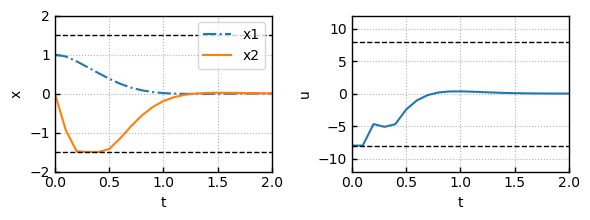

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.3)) 
ax[0].plot(resp.time, resp.outputs[0], label='x1', ls='-.') # 状態のグラフ
ax[0].plot(resp.time, resp.outputs[1], label='x2', ) # 状態のグラフ
ax[1].plot(resp.time, resp.outputs[2]) # 制御入力のグラフ

ax[0].set_xlim([0,2])
ax[1].set_xlim([0,2])
ax[0].set_ylim([-2,2])
ax[1].set_ylim([-12,12])
# 制約条件をプロット
ax[0].hlines(xmin, 0, 2, colors='black', linestyle='dashed', lw=1)
ax[0].hlines(xmax, 0, 2, colors='black', linestyle='dashed', lw=1)
ax[1].hlines(umin, 0, 2, colors='black', linestyle='dashed', lw=1)
ax[1].hlines(umax, 0, 2, colors='black', linestyle='dashed', lw=1)
plot_set(ax[0], 't', 'x', 'best')
plot_set(ax[1], 't', 'u')
plt.tight_layout()

fig.savefig("c7_mpc.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)